### 1. Data Cleaning & Imputation

**Load Raw Data**

>We start by importing the raw training and test datasets. These will serve as the foundation for all future transformations, imputations, and feature engineering work. This step ensures we’re working with the unmodified data straight from the competition source.

In [1]:
import pandas as pd
# Load data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

**Extract GroupID from PassengerId & Track Missing Values**

>The PassengerId is formatted as `GroupID_PassengerNumber`. Splitting this gives us a `GroupID`, which may be useful for inferring transport outcomes within families or travel groups. We also add a column to track how many fields are missing per row, which may indicate `CryoSleep` or data quality issues.

In [2]:
# Extract GroupID
train['GroupID'] = train['PassengerId'].str.split('_').str[0]
test['GroupID'] = test['PassengerId'].str.split('_').str[0]

# Track total missing fields per row
train['MissingCount'] = train.isnull().sum(axis=1)
test['MissingCount'] = test.isnull().sum(axis=1)


**Impute CryoSleep Based on Spending Behavior**

>Passengers in `CryoSleep` almost never have spending in categories like `Spa`, `VRDeck`, `ShoppingMall`, etc. So if all spending is zero or missing, and `CryoSleep` is `null`, we can safely assume they were asleep.

>We also create a `NoSpend` flag to capture passengers with no non-zero spending, useful for downstream analysis.

In [3]:
# Spending categories
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create 'NoSpend' flag
train['NoSpend'] = train[spend_cols].fillna(0).sum(axis=1) == 0
test['NoSpend'] = test[spend_cols].fillna(0).sum(axis=1) == 0

# Impute CryoSleep as True when no spend and missing CryoSleep
train['CryoSleep'] = train.apply(
    lambda row: True if pd.isna(row['CryoSleep']) and row['NoSpend'] else row['CryoSleep'],
    axis=1
)
test['CryoSleep'] = test.apply(
    lambda row: True if pd.isna(row['CryoSleep']) and row['NoSpend'] else row['CryoSleep'],
    axis=1
)


**Fill Remaining CryoSleep Nulls & Flag Missing**

>We’ve already handled `CryoSleep` where `NoSpend == True`. For any remaining nulls, we’ll fill with the most common value (likely `False`) to avoid model errors - but we also track those rows with a `CryoSleep_missing` flag so the model can learn from that uncertainty.

In [4]:
# Flag missing CryoSleep
train['CryoSleep_missing'] = train['CryoSleep'].isna()
test['CryoSleep_missing'] = test['CryoSleep'].isna()

# Fill remaining CryoSleep with mode
train['CryoSleep'] = train['CryoSleep'].fillna(train['CryoSleep'].mode()[0])
test['CryoSleep'] = test['CryoSleep'].fillna(train['CryoSleep'].mode()[0])

C:\Users\andre\AppData\Local\Temp\ipykernel_17812\2420040901.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['CryoSleep'] = train['CryoSleep'].fillna(train['CryoSleep'].mode()[0])
C:\Users\andre\AppData\Local\Temp\ipykernel_17812\2420040901.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['CryoSleep'] = test['CryoSleep'].fillna(train['CryoSleep'].mode()[0])


**Impute Spending Columns Based on CryoSleep**

>Passengers in `CryoSleep` didn’t spend - so for any missing spending values and `CryoSleep=True`, we can safely impute zero. For other missing values, we fill with 0 as a default while preserving missingness flags (`*_missing`) for each amenity.

In [5]:
# Impute spending columns based on CryoSleep
for col in spend_cols:
    # Missingness flag
    train[f'{col}_missing'] = train[col].isna()
    test[f'{col}_missing'] = test[col].isna()
    
    # If CryoSleep == True and value is missing → set to 0
    train.loc[(train['CryoSleep'] == True) & (train[col].isna()), col] = 0
    test.loc[(test['CryoSleep'] == True) & (test[col].isna()), col] = 0

    # Fill remaining missing values with 0 (safe fallback)
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)


**Impute VIP Based on CryoSleep & Mode**

>Passengers in CryoSleep rarely engaged with luxury services, and thus were unlikely to be VIP. We impute missing VIP values accordingly, and fall back to the mode where necessary. A missingness flag helps preserve potential predictive value in VIP uncertainty.

In [6]:
# VIP missing flag
train['VIP_missing'] = train['VIP'].isna()
test['VIP_missing'] = test['VIP'].isna()

# Impute VIP = False when CryoSleep = True and VIP is missing
train.loc[(train['CryoSleep'] == True) & (train['VIP'].isna()), 'VIP'] = False
test.loc[(test['CryoSleep'] == True) & (test['VIP'].isna()), 'VIP'] = False

# Fill remaining VIP with mode
train['VIP'] = train['VIP'].fillna(train['VIP'].mode()[0])
test['VIP'] = test['VIP'].fillna(train['VIP'].mode()[0])


C:\Users\andre\AppData\Local\Temp\ipykernel_17812\3685001050.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['VIP'] = train['VIP'].fillna(train['VIP'].mode()[0])
C:\Users\andre\AppData\Local\Temp\ipykernel_17812\3685001050.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['VIP'] = test['VIP'].fillna(train['VIP'].mode()[0])


**Impute Age with Median & Flag Missingness**

>Missing Age values are imputed using the dataset median, preserving distribution shape without introducing bias. A missingness flag allows the model to learn from absence of age data, which may itself be informative.

In [7]:
# Age missing flag
train['Age_missing'] = train['Age'].isna()
test['Age_missing'] = test['Age'].isna()

# Fill missing with median
age_median = train['Age'].median()
train['Age'] = train['Age'].fillna(age_median)
test['Age'] = test['Age'].fillna(age_median)

**Split & Clean Cabin Field**

>The Cabin field encodes three subcomponents: deck, number, and side. We split these for better model interpretability. Since many values are missing, we flag and impute `CabinDeck` and `CabinSide` with `"Unknown"`. `CabinNum` is retained for now, but may be dropped or binned later if shown to be uninformative.

In [8]:
# Split Cabin into Deck / Num / Side
for df in [train, test]:
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)

# Flag missing components
train['CabinDeck_missing'] = train['CabinDeck'].isna()
test['CabinDeck_missing'] = test['CabinDeck'].isna()
train['CabinSide_missing'] = train['CabinSide'].isna()
test['CabinSide_missing'] = test['CabinSide'].isna()

# Fill missing Deck/Side with 'Unknown'
train['CabinDeck'] = train['CabinDeck'].fillna('Unknown')
test['CabinDeck'] = test['CabinDeck'].fillna('Unknown')
train['CabinSide'] = train['CabinSide'].fillna('Unknown')
test['CabinSide'] = test['CabinSide'].fillna('Unknown')

# Optionally fill or drop CabinNum
train['CabinNum'] = train['CabinNum'].fillna(-1).astype(float)
test['CabinNum'] = test['CabinNum'].fillna(-1).astype(float)

**Verify Cleaning & Imputation**

>Before moving to feature engineering, we confirm all transformations were successful. This includes inspecting new columns, verifying missing value handling, and ensuring expected distributions for imputed fields.

In [9]:
# Show new columns added
added_cols = [col for col in train.columns if col not in pd.read_csv('../data/train.csv').columns]
print("Added Columns:")
for col in added_cols:
    print(f" - {col}")

# Preview head of new features
display(train[added_cols].head())

# Summary of missing values (should now be 0 or only in fields we chose to ignore like Name)
print("\n🧹 Missing Value Summary:")
missing_summary = train.isnull().sum()
display(missing_summary[missing_summary > 0].sort_values(ascending=False))




Added Columns:
 - GroupID
 - MissingCount
 - NoSpend
 - CryoSleep_missing
 - RoomService_missing
 - FoodCourt_missing
 - ShoppingMall_missing
 - Spa_missing
 - VRDeck_missing
 - VIP_missing
 - Age_missing
 - CabinDeck
 - CabinNum
 - CabinSide
 - CabinDeck_missing
 - CabinSide_missing


,GroupID,MissingCount,NoSpend,CryoSleep_missing,RoomService_missing,FoodCourt_missing,ShoppingMall_missing,Spa_missing,VRDeck_missing,VIP_missing,Age_missing,CabinDeck,CabinNum,CabinSide,CabinDeck_missing,CabinSide_missing
0,0001,0,True,False,False,False,False,False,False,False,False,B,0.0,P,False,False
1,0002,0,False,False,False,False,False,False,False,False,False,F,0.0,S,False,False
2,0003,0,False,False,False,False,False,False,False,False,False,A,0.0,S,False,False
3,0003,0,False,False,False,False,False,False,False,False,False,A,0.0,S,False,False
4,0004,0,False,False,False,False,False,False,False,False,False,F,1.0,S,False,False



🧹 Missing Value Summary:


HomePlanet     201
Name           200
Cabin          199
Destination    182
dtype: int64

**New columns added:**

Successfully introduced 16 engineered or imputation-related columns, including:

Structural: `GroupID`, `CabinDeck`, `CabinNum`, `CabinSide`

Missingness flags: `CryoSleep_missing`, `VIP_missing`, all spending categories

Behavioral: `NoSpend`, `MissingCount`

**Missing values left:**

>Only columns intentionally ignored:

| Column        | Notes                                   |
| ------------- | --------------------------------------- |
| `HomePlanet`  | Possibly noisy — wait on imputing       |
| `Name`        | Text column — may extract surname later |
| `Cabin`       | Already split into components           |
| `Destination` | Will likely fill from GroupID           |


**Next Step: Feature Engineering**

>Now onto Step 2 of the plan:

**Feature Engineering (Part 1): Activity & Group**

Now to generate new features based on behavioral patterns and relationships:

- `NoActivity` — True if a passenger spent zero across all categories and was not VIP

- `GroupSize` — Total number of passengers sharing a GroupID

- `IsAlone` — True if GroupSize == 1

>These features are powerful signals for inferring CryoSleep and Transport likelihood.



In [10]:
# NoActivity: didn't spend anything and not a VIP
train['NoActivity'] = (train['NoSpend']) & (train['VIP'] == False)
test['NoActivity'] = (test['NoSpend']) & (test['VIP'] == False)

# GroupSize
group_counts = train['GroupID'].value_counts()
train['GroupSize'] = train['GroupID'].map(group_counts)
test['GroupSize'] = test['GroupID'].map(group_counts)  # Some GroupIDs in test may be unseen
test['GroupSize'] = test['GroupSize'].fillna(1)  # Assume unseen = solo

# IsAlone flag
train['IsAlone'] = train['GroupSize'] == 1
test['IsAlone'] = test['GroupSize'] == 1

**Feature Engineering (Part 2): Age Binning**

Age alone wasn’t a strong predictor, but binning may expose hidden patterns. 

We’ll create:

- `AgeGroup` — Categorical bin of passenger age:

    - `"Child"`: under 13

    - `"Teen"`: 13–19

    - `"YoungAdult"`: 20–35

    - `"Adult"`: 36–60

    - `"Senior"`: over 60

This creates human-interpretable categories that could align with behavior or CryoSleep tendencies.

In [11]:
def bin_age(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 13:
        return 'Child'
    elif age < 20:
        return 'Teen'
    elif age < 36:
        return 'YoungAdult'
    elif age < 61:
        return 'Adult'
    else:
        return 'Senior'

train['AgeGroup'] = train['Age'].apply(bin_age)
test['AgeGroup'] = test['Age'].apply(bin_age)

In [12]:
train['AgeGroup'].value_counts()
print(train['AgeGroup'].value_counts(dropna=False))

AgeGroup
YoungAdult    4022
Adult         2293
Teen          1352
Child          806
Senior         220
Name: count, dtype: int64


**Add Group Size Feature**

>Passengers with the same `GroupID` (from the `PassengerId` prefix) are likely traveling together - as family or companions. I'll count the number of passengers per group and assign that value to each row as a new `GroupSize` feature. This may help us identify behaviors like group transport tendencies or shared decisions (e.g. all going into CryoSleep).

In [13]:
# Add GroupSize feature based on GroupID counts
train['GroupSize'] = train['GroupID'].map(train['GroupID'].value_counts())
test['GroupSize'] = test['GroupID'].map(test['GroupID'].value_counts())
print(train['GroupSize'].value_counts(dropna=False))

GroupSize
1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: count, dtype: int64


---

**Correlation with `Transported`**

> Before modeling, let's take a look at how our engineered features relate to the target variable. We'll use the training set only and start with simple correlation for numerical features, and then explore category distributions.


In [14]:
# Temporarily map Transported to 1/0 for correlation
train_corr = train.copy()
train_corr['Transported'] = train_corr['Transported'].map({True: 1, False: 0})

# Select numeric columns
numeric_cols = train_corr.select_dtypes(include='number').columns.tolist()

# Compute correlation
correlations = train_corr[numeric_cols].corr()['Transported'].sort_values(ascending=False)

# Display correlation
correlations.drop('Transported')  # Drop self-correlation

GroupSize       0.082644
FoodCourt       0.045583
ShoppingMall    0.009391
MissingCount    0.004826
CabinNum       -0.043830
Age            -0.074233
VRDeck         -0.204874
Spa            -0.218545
RoomService    -0.241124
Name: Transported, dtype: float64

| Feature        | Correlation | Interpretation                                                                                              |
| -------------- | ----------- | ----------------------------------------------------------------------------------------------------------- |
| `GroupSize`    | **+0.08**   | Slight trend: larger groups may be more likely to be transported.                                           |
| `FoodCourt`    | **+0.05**   | Tiny positive signal - maybe small spenders are awake and less likely to be transported.                    |
| `ShoppingMall` | **+0.009**  | Negligible.                                                                                                 |
| `MissingCount` | **+0.0048** | Totally negligible.                                                                                         |
| `CabinNum`     | **-0.044**  | Slight trend that lower-numbered cabins have higher transport odds. Maybe front-of-ship bias?               |
| `Age`          | **-0.074**  | Slight trend that younger people are more likely to be transported. (Consistent with `AgeGroup` insight.)   |
| `VRDeck`       | **-0.204**  | Stronger signal - more VRDeck spend → less likely to be transported. Possibly awake/engaged passengers.     |
| `Spa`          | **-0.219**  | Even stronger - spa usage inversely related to being transported.                                           |
| `RoomService`  | **-0.241**  | Strongest inverse signal - room service usage likely means awake, aware, not in CryoSleep, not transported. |


**Checking Multicollinearity**

>I'll use a correlation heatmap to identify highly correlated features. This helps avoid feeding redundant signals into the model, which can skew importance and introduce noise. Spend categories and total spend are prime suspects.

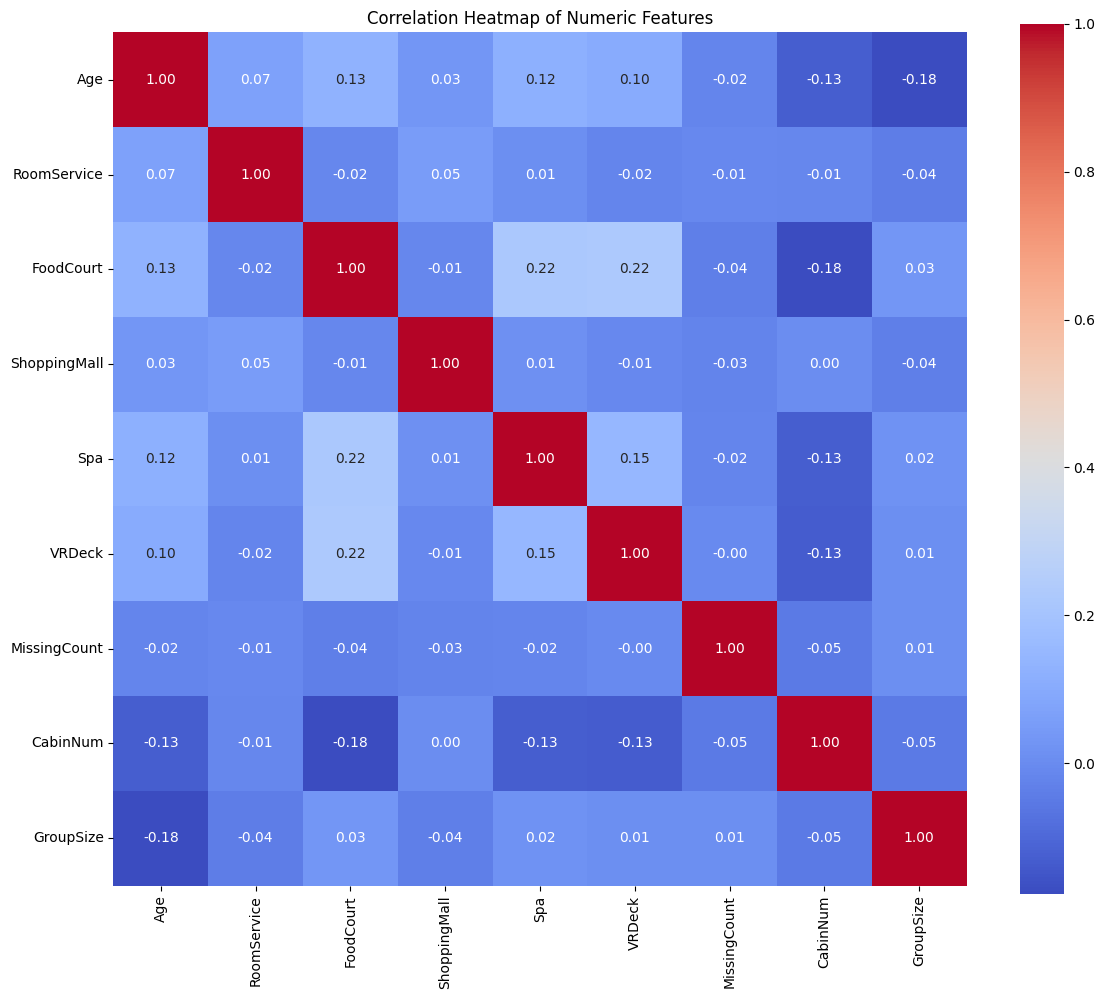

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric features for correlation analysis
numeric_features = train.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

**Quick Interpretation**

- No strong correlations (> 0.8) between any pair — that’s good. We're not looking at truly redundant features.

- The spending categories (`Spa`, `VRDeck`, `FoodCourt`, etc.) all hover in the low correlation range with one another. Highest is:

    - `FoodCourt` vs `Spa`: 0.22

    - `FoodCourt` vs `VRDeck`: 0.22

    - `Spa` vs `VRDeck`: 0.15

These values are low — it tells us each spend category is relatively independent in user behavior.


**What That Means**

We don’t need to drop any spend columns yet due to multicollinearity. They offer distinct signals. That said:

- It might still be useful to create flags like `SpentAt_Spa`, `SpentAt_VRDeck`, etc.

- And `TotalSpent` (if we bring it back later) could capture global patterns, while individual spend categories might detect specific behaviors (e.g. VRDeck = entertainment-oriented).

**Save Final Datasets**

Now that feature engineering and cleaning are complete, we export the transformed `train` and `test` datasets as CSV files for use in the modeling notebook.

In [16]:
# Save cleaned and feature-engineered data
train.to_csv('../data/train_clean.csv', index=False)
test.to_csv('../data/test_clean.csv', index=False)